# SARモデル(SLM、SEM)

# ライブラリ
- spregは同時自己回帰モデル(SAR)を推定するためのライブラリ
  - https://pysal.org/spreg/
- libpysalはpysal系列のライブラリで、空間重み行列や、サンプルデータのロードなどができる
  - https://pysal.org/libpysal/

In [ ]:
!pip install lmdiag libpysal spreg pysal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from pytz import timezone
from datetime import datetime, timedelta
import json
import itertools
from tqdm import tqdm
from sklearn.metrics import mean_squared_log_error, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import lmdiag
from libpysal.weights import Queen, Rook, KNN
import geopandas as gpd
from spreg import ML_Lag, ML_Error
import libpysal
from libpysal.examples import load_example
from pysal.viz import splot
from splot.esda import plot_moran
from pysal.explore import esda
from pysal.lib import weights
import warnings
warnings.filterwarnings("ignore")

In [2]:
boston = load_example('Bostonhsg')
#print(boston.get_file_list())
db = libpysal.io.open(boston.get_path("boston.dbf"),'r')
df = gpd.read_file(boston.get_path("boston.shp"))

display(df.head())
print(df.shape)
print(df.columns)

,ID,TOWN,TOWNNO,TRACT,LON,LAT,x,y,MEDV,CMEDV,...,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,geometry
0,1.0,0.0,0.0,2011.0,-70.955,42.2550,338.73,4679.73,24.0,24.0,...,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,POINT (338.730 4679.730)
1,2.0,0.0,1.0,2021.0,-70.950,42.2875,339.23,4683.33,21.6,21.6,...,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,POINT (339.230 4683.330)
2,3.0,0.0,1.0,2022.0,-70.936,42.2830,340.37,4682.80,34.7,34.7,...,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,POINT (340.370 4682.800)
3,4.0,0.0,2.0,2031.0,-70.928,42.2930,341.05,4683.89,33.4,33.4,...,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,POINT (341.050 4683.890)
4,5.0,0.0,2.0,2032.0,-70.922,42.2980,341.56,4684.44,36.2,36.2,...,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,POINT (341.560 4684.440)


(506, 24)
Index(['ID', 'TOWN', 'TOWNNO', 'TRACT', 'LON', 'LAT', 'x', 'y', 'MEDV',
       'CMEDV', 'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS',
       'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'geometry'],
      dtype='object')


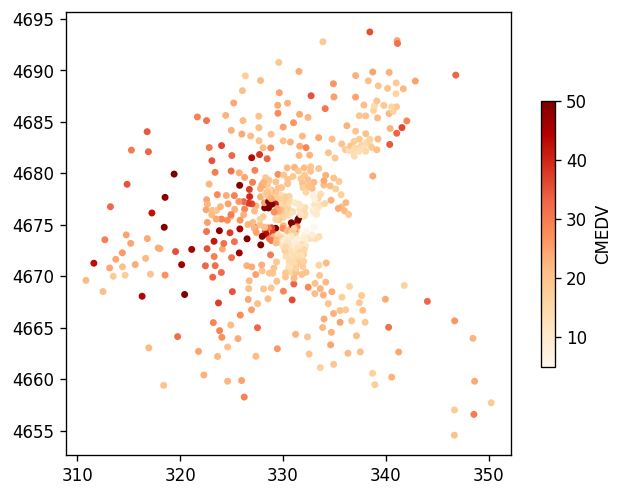

In [3]:
fig, ax = plt.subplots(dpi=120)
df.plot(
    ax=ax,
    column = "CMEDV",
    cmap = "OrRd",
    legend = True,
    legend_kwds = {"label": "CMEDV", "shrink": 0.6},
    s=10
);

近接行列の作成

- 距離減衰ベース
  - 閾値がthreshhold[m]で設定できる。binary=Trueは1/0で表現、binary=Falseで1/dij / 0で表現する。
  - https://darribas.org/gds_course/content/bE/lab_E.html#distance
  - https://pysal.org/libpysal/generated/libpysal.weights.DistanceBand.html

- 近傍n点
  - https://pysal.org/libpysal/generated/libpysal.weights.KNN.html

- チェス系(Queen, Rook)  


近接行列の可視化
- https://pysal.org/notebooks/lib/libpysal/weights.html

In [4]:
# 距離減衰ベース
#w = weights.DistanceBand.from_dataframe(df, threshold=1000, binary=True)

# 近傍n点ベース
#w = weights.distance.KNN.from_dataframe(df, k=4)

# ルーク
w = Rook.from_dataframe(df)

w.transform = 'R' # 行基準化
w.full()[0]

array([[0.        , 0.        , 0.11111111, ..., 0.        , 0.        ,
        0.11111111],
       [0.        , 0.        , 0.125     , ..., 0.        , 0.        ,
        0.        ],
       [0.125     , 0.125     , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.14285714,
        0.14285714],
       [0.        , 0.        , 0.        , ..., 0.25      , 0.        ,
        0.25      ],
       [0.125     , 0.        , 0.        , ..., 0.125     , 0.125     ,
        0.        ]])

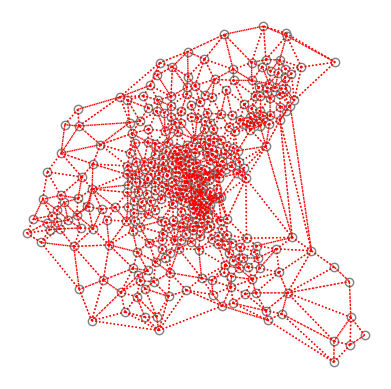

In [5]:
ax = df.plot(edgecolor='grey', facecolor='w')
f, ax = w.plot(df, ax=ax,
        edge_kws=dict(color='r', linestyle=':', linewidth=1),
        node_kws=dict(marker=''))
ax.set_axis_off()

目的変数のモランI統計量を確認する。空間相関がある場合は、普通の回帰分析でなく空間相関を考慮できるモデルを使う必要がある。

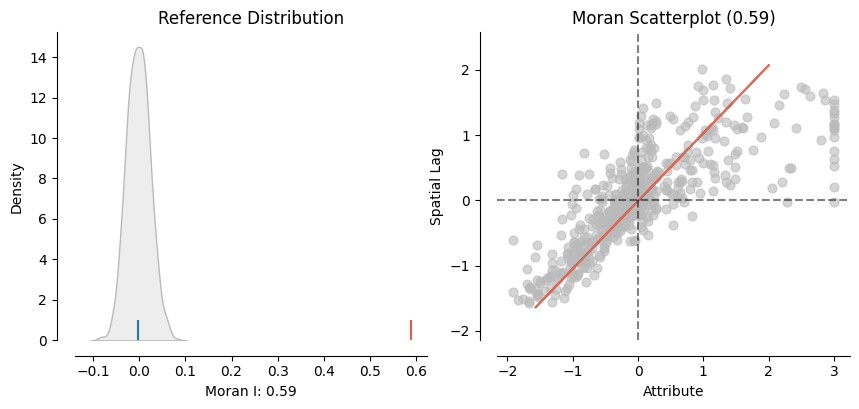

In [6]:
target = "CMEDV"

moran_i_obj = esda.moran.Moran(y=df[target], w=w)
plot_moran(moran=moran_i_obj);

In [7]:
# 説明変数
ex_columns = ["CRIM", "RM", "LSTAT"]

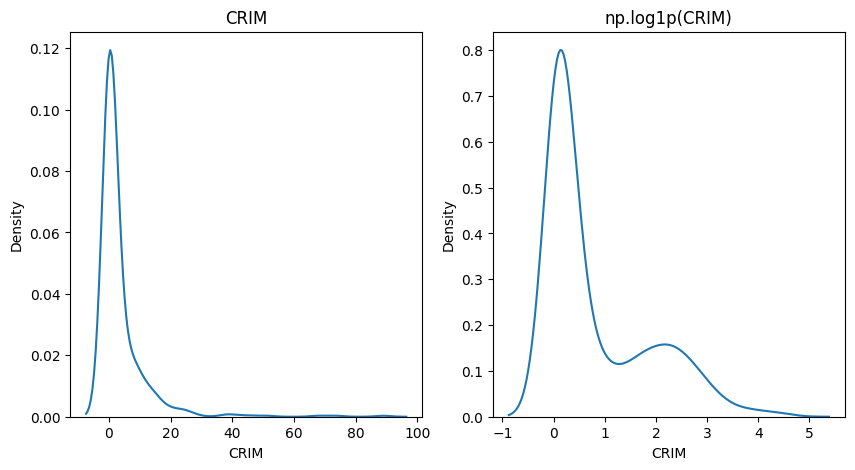

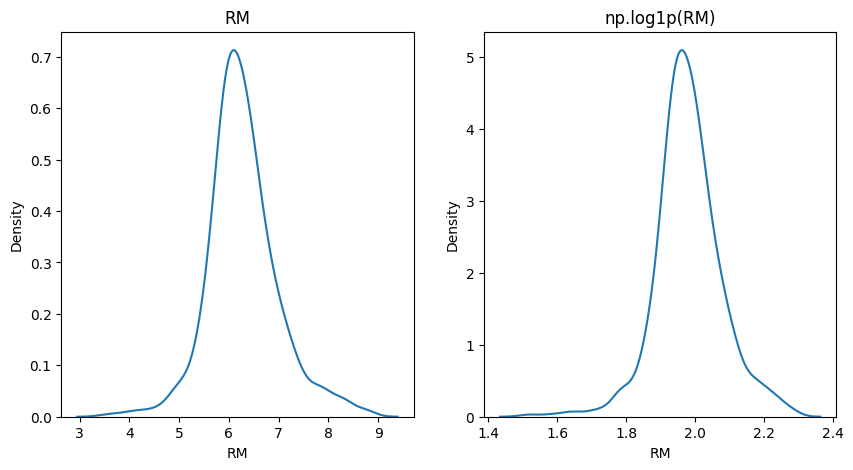

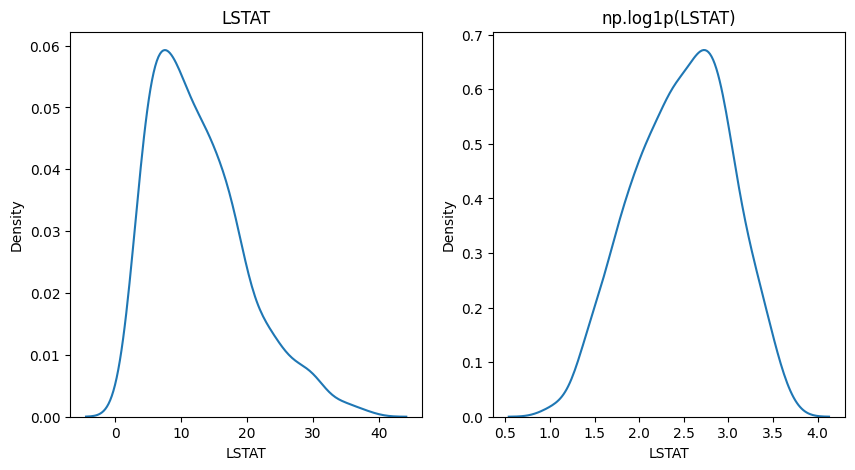

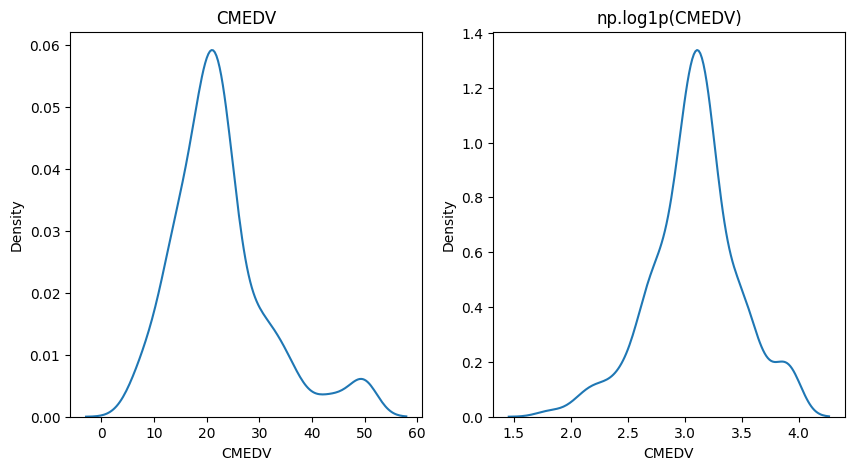

In [8]:
for col in ex_columns+[target]:
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax=ax.flatten()
    sns.kdeplot(df[col], ax=ax[0])
    sns.kdeplot(np.log1p(df[col]), ax=ax[1])
    ax[0].set_title(f"{col}"); ax[1].set_title(f"np.log1p({col})")
    plt.show()

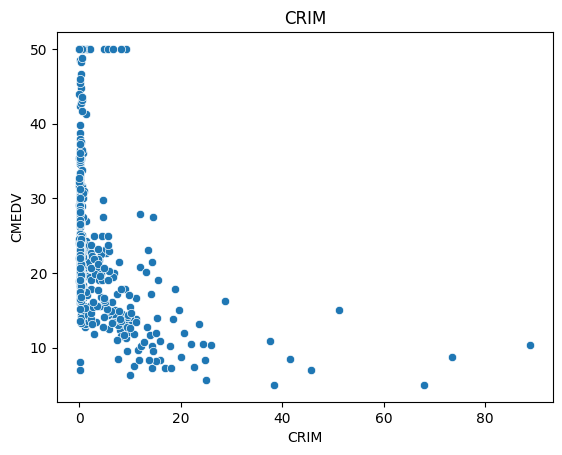

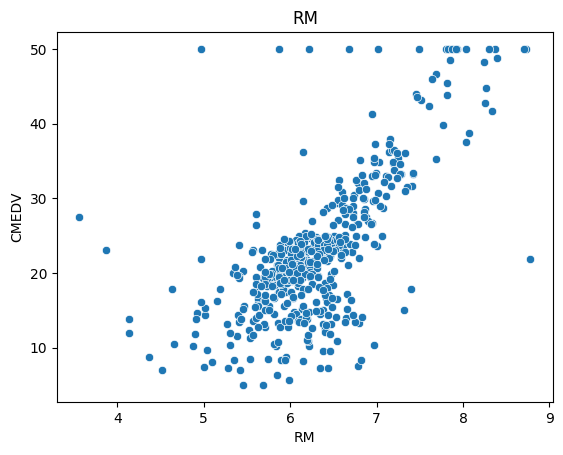

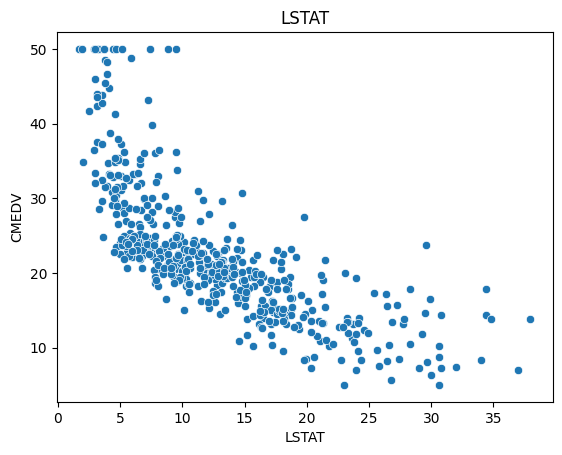

In [9]:
for col in ex_columns:
    fig, ax = plt.subplots()
    sns.scatterplot(x=df[col], y=df[target], ax=ax)
    ax.set_title(f"{col}")
    plt.show()

In [10]:
df_train = df.copy()

df_train["CMEDVlr"] = np.log1p(df_train["CMEDV"])
df_train["RM2"] = df_train["RM"]**2
df_train["LSTATlr"] = np.log1p(df_train["LSTAT"])

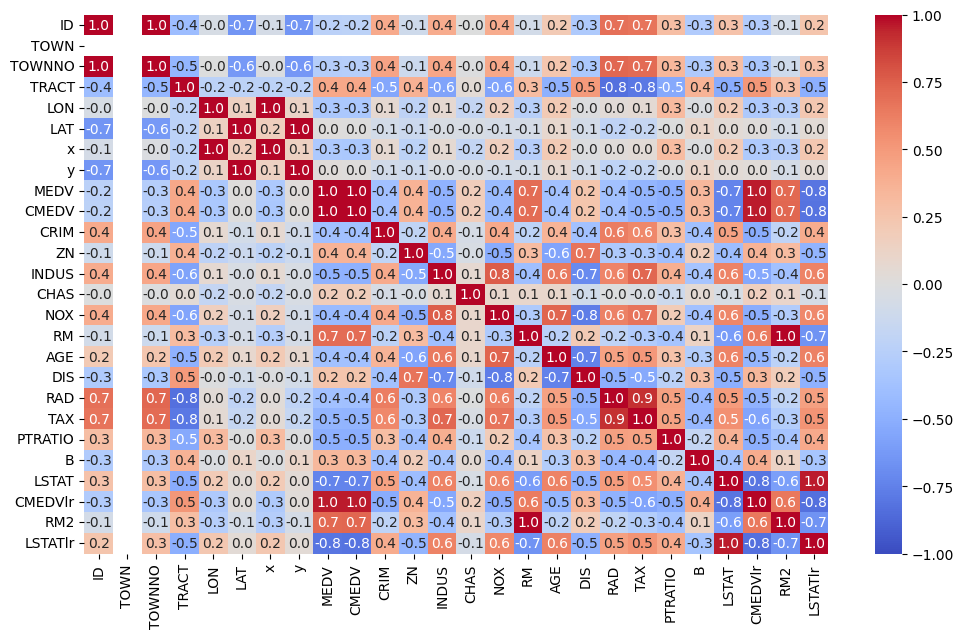

In [23]:
target = "CMEDVlr"
ex_columns = ["CRIM", "RM2", "LSTATlr"]

fig, ax = plt.subplots(figsize=(12, 7))
sns.heatmap(df_train.corr(), annot=True, fmt=".1f", cmap='coolwarm', vmin=-1, vmax=1, ax=ax)
plt.show()

In [22]:
#vifを計算する
def vif(df):
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif.index = df.columns
    return vif

vif(df_train[ex_columns])

,VIF Factor
CRIM,1.348779
RM2,7.097826
LSTATlr,7.964419


SLM
- ML_lagは最尤推定
- GM_lagだと2段階最小二乗法

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     CMEDVlr                Number of Observations:         506
Mean dependent var  :      3.0855                Number of Variables   :           5
S.D. dependent var  :      0.3865                Degrees of Freedom    :         501
Pseudo R-squared    :      0.8373
Spatial Pseudo R-squared:  0.7501
Sigma-square ML     :       0.024                Log likelihood        :     210.429
S.E of regression   :       0.156                Akaike info criterion :    -410.858
                                                 Schwarz criterion     :    -389.726

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------

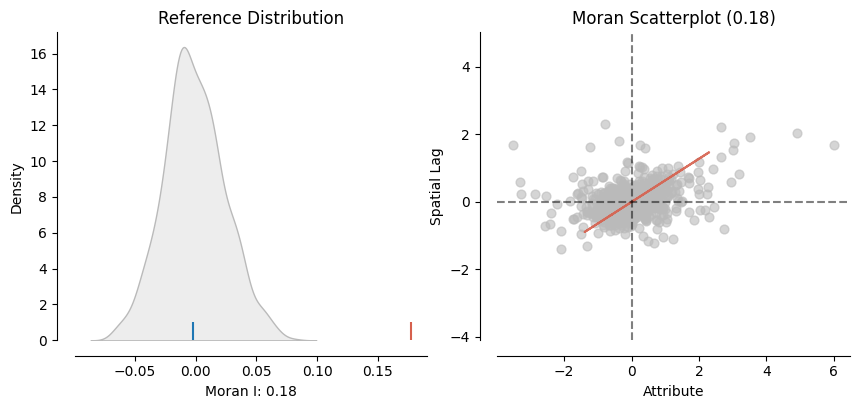

In [15]:
y = df_train[target].to_numpy()
X = df_train[ex_columns].to_numpy()

model_lag = ML_Lag(y, X, w, name_y=target, name_x=ex_columns)
print(model_lag.summary)

# 残差に空間相関がないか確認
moran_i_obj = esda.moran.Moran(y=model_lag.u, w=w)
plot_moran(moran=moran_i_obj);

SEM

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL ERROR (METHOD = FULL)
-------------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     CMEDVlr                Number of Observations:         506
Mean dependent var  :      3.0855                Number of Variables   :           4
S.D. dependent var  :      0.3865                Degrees of Freedom    :         502
Pseudo R-squared    :      0.7546
Sigma-square ML     :       0.020                Log likelihood        :     238.101
S.E of regression   :       0.141                Akaike info criterion :    -468.202
                                                 Schwarz criterion     :    -451.296

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------------------------------------

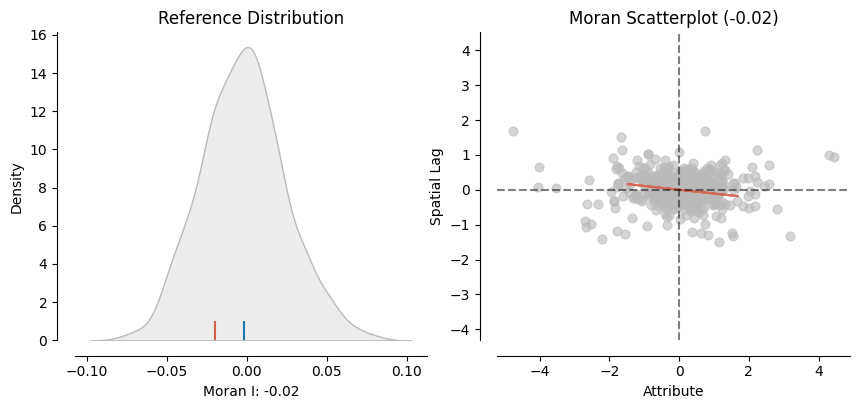

In [17]:
y = df_train[target].to_numpy()
X = df_train[ex_columns].to_numpy()

model_err = ML_Error(y, X, w, name_y=target, name_x=ex_columns)
print(model_err.summary)

# 残差に空間相関がないか確認
moran_i_obj = esda.moran.Moran(y=model_err.e_filtered, w=w)
plot_moran(moran=moran_i_obj);